### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df.shape[0]

2633

In [3]:
df['media_name'].value_counts()

media_name
wired.com               929
technologyreview.com    770
theverge.com            468
theatlantic.com         339
medium.com              109
thespectrum.com          18
Name: count, dtype: int64

In [8]:
df = df[df['media_name'] == 'technologyreview.com'] # Filter by magazine
df = df.reset_index(drop=True)

df.head(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the..."


### Clean Data

In [9]:
df.columns

Index(['id', 'indexed_date', 'language', 'media_name', 'media_url',
       'publish_date', 'title', 'url', 'year', 'text', 'text_downloaded',
       'GPE', 'IND', 'ORG'],
      dtype='object')

### Lematization

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
# df['text_clean'] = df['title'] + ' ' + df['text'] 
df['text_clean'] = df['text'] 

In [12]:
df['text_clean']

0      2024 Innovator of the Year: Shawn Shan builds ...
1      What impact will AI have on video game develop...
2      To be more useful, robots need to become lazie...
3      Roblox is launching a generative AI that build...
4      Sponsored\nIntegrating security from code to c...
                             ...                        
765                                                     
766                                                     
767    Sponsored\nThese five AI developments will sha...
768                                                     
769    This avocado armchair could be the future of A...
Name: text_clean, Length: 770, dtype: object

In [14]:
# Calcula la cantidad de palabras por fila
df["word_count"] = df["text_clean"].apply(lambda x: len(x.split()))

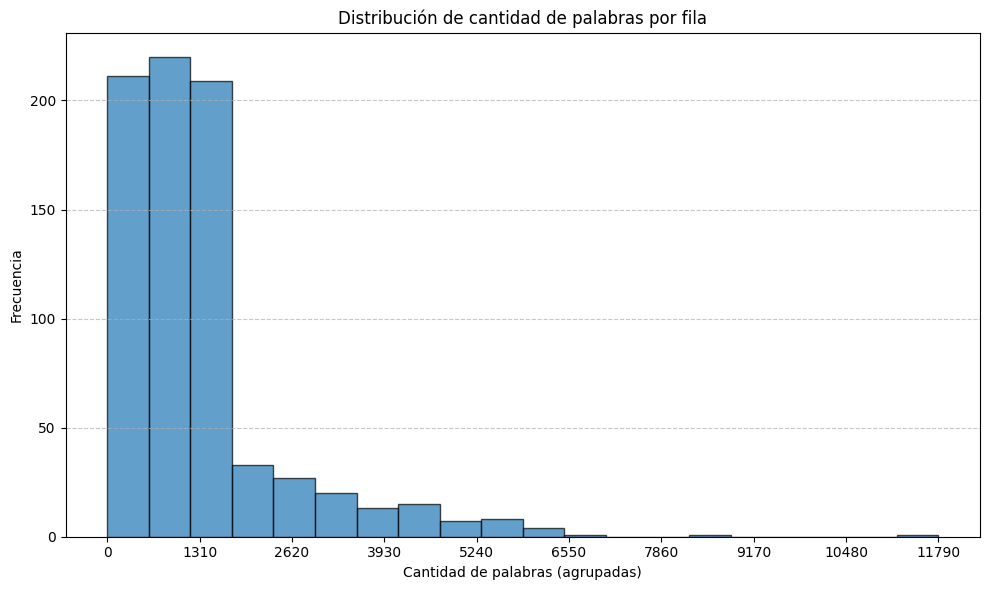

In [15]:
# Genera un histograma con ajustes
plt.figure(figsize=(10, 6))
plt.hist(df["word_count"], bins=20, edgecolor="black", alpha=0.7)  # Ajusta bins a 20 intervalos
plt.title("Distribución de cantidad de palabras por fila")
plt.xlabel("Cantidad de palabras (agrupadas)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Ajuste de ticks en el eje X
plt.xticks(np.linspace(df["word_count"].min(), df["word_count"].max(), 10).astype(int))
plt.tight_layout()
plt.show()

In [16]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [17]:
# Parsing

def parse_document(text):
    """
    Parses the text using spaCy.
    Returns a processed spaCy document.
    """
    return nlp(text)


df['parsed_doc'] = df['text_clean'].apply(parse_document)



In [18]:
df['parsed_doc']

0      (2024, Innovator, of, the, Year, :, Shawn, Sha...
1      (What, impact, will, AI, have, on, video, game...
2      (To, be, more, useful, ,, robots, need, to, be...
3      (Roblox, is, launching, a, generative, AI, tha...
4      (Sponsored, \n, Integrating, security, from, c...
                             ...                        
765                                                   ()
766                                                   ()
767    (Sponsored, \n, These, five, AI, developments,...
768                                                   ()
769    (This, avocado, armchair, could, be, the, futu...
Name: parsed_doc, Length: 770, dtype: object

In [19]:
# Calcula la cantidad de palabras por fila

# Custom words to remove
CUSTOM_STOP_WORDS = {'ai', 'say', 'year', 'way', 'use', 'need', 'technology', 'tech', 'mit', 'review'}

# Function to clean tokens
def clean_tokens(doc):
    """
    Cleans tokens from the parsed document:
    - Filters tokens by POS tags: PROPN, NOUN, and optionally VERB.
    - Uses lemmatized forms (lemma_) instead of original text.
    - Excludes stopwords, punctuation, and custom-defined words.
    """
    tokens = [
        token.lemma_ for token in doc
        # if token.pos_ in {"PROPN", "NOUN", "VERB"}  # Keep specific POS tags
        if token.pos_ in {"PROPN", "NOUN"}  # Keep specific POS tags
        and token.text.lower() not in STOP_WORDS    # Exclude stopwords
        and token.is_alpha                          # Keep only alphabetic tokens
        # and token.text.lower() not in string.punctuation  # Exclude punctuation
        and token.text.lower() not in CUSTOM_STOP_WORDS # Exclude custom-defined words
    ]
    return tokens


df['parsed_lemmas'] = df['parsed_doc'].apply(lambda doc: ' '.join(clean_tokens(doc)))

# df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))

df['parsed_lemmas'].iloc[0]

'Innovator Shawn Shan tool artist Shan Glaze Nightshade tool artist copyright Shawn Shan Innovators rest honoree image model DALL E Midjourney Diffusion kick boom artist similarity image work data set model knockoff style work client tool image artist rate artist tool Shawn Shan phd student computer science University Chicago Innovator Shan start security privacy undergraduate project Fawkes tool face recognition conversation artist boom middle fight field impact artist Shan advisor Ben Zhao Innovators list Heather Zheng list tool input artist Shan algorithm Glaze tool artist style mimicry Glaze October Shan team tool Nightshade layer poison image image model image data set poison machine model training datum model output algorithm change pixel image machine model response Glaze Shan team backlash booster medium attempt protection artist Glaze time Nightshade art platform Cara artist protection work image Glaze paper award Internet Defense Prize Usenix Security Symposium computer secur

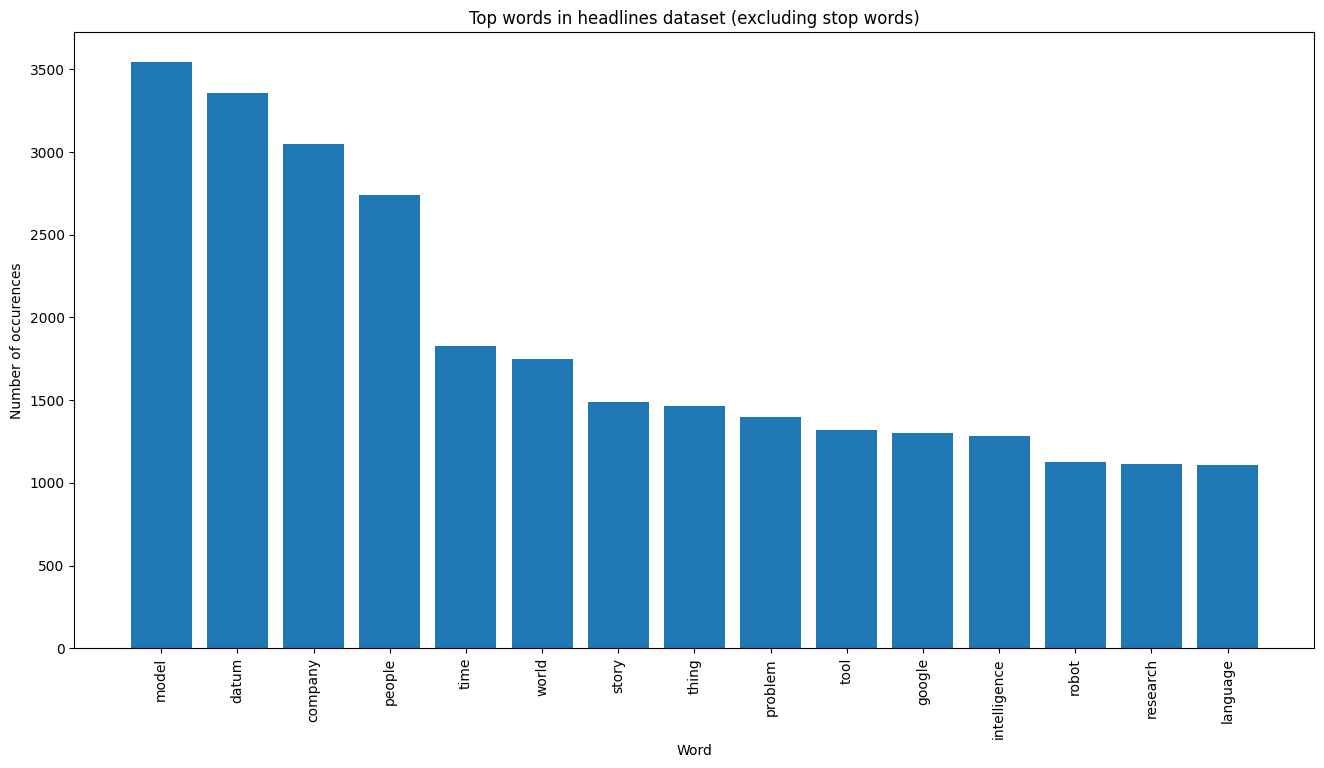

In [20]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['parsed_lemmas'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Save clean text

In [23]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [169]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [24]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...",2024 Innovator of the Year: Shawn Shan builds ...,941,"(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator Shawn Shan tool artist Shan Glaze Ni...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...",What impact will AI have on video game develop...,1366,"(What, impact, will, AI, have, on, video, game...",impact video game development working conditio...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","To be more useful, robots need to become lazie...",1772,"(To, be, more, useful, ,, robots, need, to, be...",robot Smarter datum processing machine energy ...


In [25]:
df.shape

(770, 18)

In [26]:
df['parsed_lemmas'].isnull().sum()

np.int64(0)

In [174]:
# df = df.dropna(subset=['clean_text'])

### Temperature

In [27]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color
72,5204ee38dfcb92e374e7fd023b34d912c49980fb026a69...,2024-07-03 15:24:38.516007,en,technologyreview.com,technologyreview.com,2024-07-03,A way to let robots learn by listening will ma...,https://www.technologyreview.com/2024/07/03/10...,2024,A way to let robots learn by listening will ma...,True,[],"[Zeyi Liu, Shuran Song, Dmitry Berenson, Beren...","[AI Lab, Stanford University, Stanford, Velcro...",A way to let robots learn by listening will ma...,909,"(A, way, to, let, robots, learn, by, listening...",robot listening robot warehouse home vision ro...,2,#0000ff
539,6d505884f6763222a9043bf80ba4d956eaa5cfc5cec948...,2024-05-01 04:41:18.303513,en,technologyreview.com,technologyreview.com,2022-09-27,Maximize data outcomes by investing in people ...,https://www.technologyreview.com/2022/09/27/10...,2022,Sponsored\nMaximize data outcomes by investing...,True,"[Kyndryl, Kyndryl, Laurel, Kyndryl, Cambridge,...","[Kyndryl, Sundar Shanmugam, Sundar Shanmugam, ...","[AI, AI, AI, MLOps, XOps, XOps, Business Lab, ...",Sponsored\nMaximize data outcomes by investing...,3757,"(Sponsored, \n, Maximize, data, outcomes, by, ...",Maximize datum outcome people system datum str...,0,#aa0055
679,616e1aecce338af22fbe7c2bc3e7226f9d8933a9660f11...,2024-09-09 12:28:35.717890,en,technologyreview.com,technologyreview.com,2021-10-26,Digital body language for the post-pandemic era,https://www.technologyreview.com/2021/10/26/10...,2021,Digital body language for the post-pandemic er...,True,[Pittsburgh],"[Erica Dhawan, Erica Dhawan, Hindi, Dhawan, Sa...","[Digital, Digital Body Language, the US Army, ...",Digital body language for the post-pandemic er...,543,"(Digital, body, language, for, the, post, -, p...",body language era Erica Dhawan MBA pause Zoom ...,-1,#ff0000


In [178]:
# df = df.dropna(subset=['year'])
# df = df.dropna(subset=['clean_text'])

In [31]:
# Filtrar filas donde word_count <= 20
df = df[df["word_count"] >= 10]
df.shape

(590, 20)

### Term Frequency

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["parsed_lemmas"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...",2024 Innovator of the Year: Shawn Shan builds ...,941,"(2024, Innovator, of, the, Year, :, Shawn, Sha...",Innovator Shawn Shan tool artist Shan Glaze Ni...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...",What impact will AI have on video game develop...,1366,"(What, impact, will, AI, have, on, video, game...",impact video game development working conditio...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...","To be more useful, robots need to become lazie...",1772,"(To, be, more, useful, ,, robots, need, to, be...",robot Smarter datum processing machine energy ...,2,#0000ff


## UMAP

c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


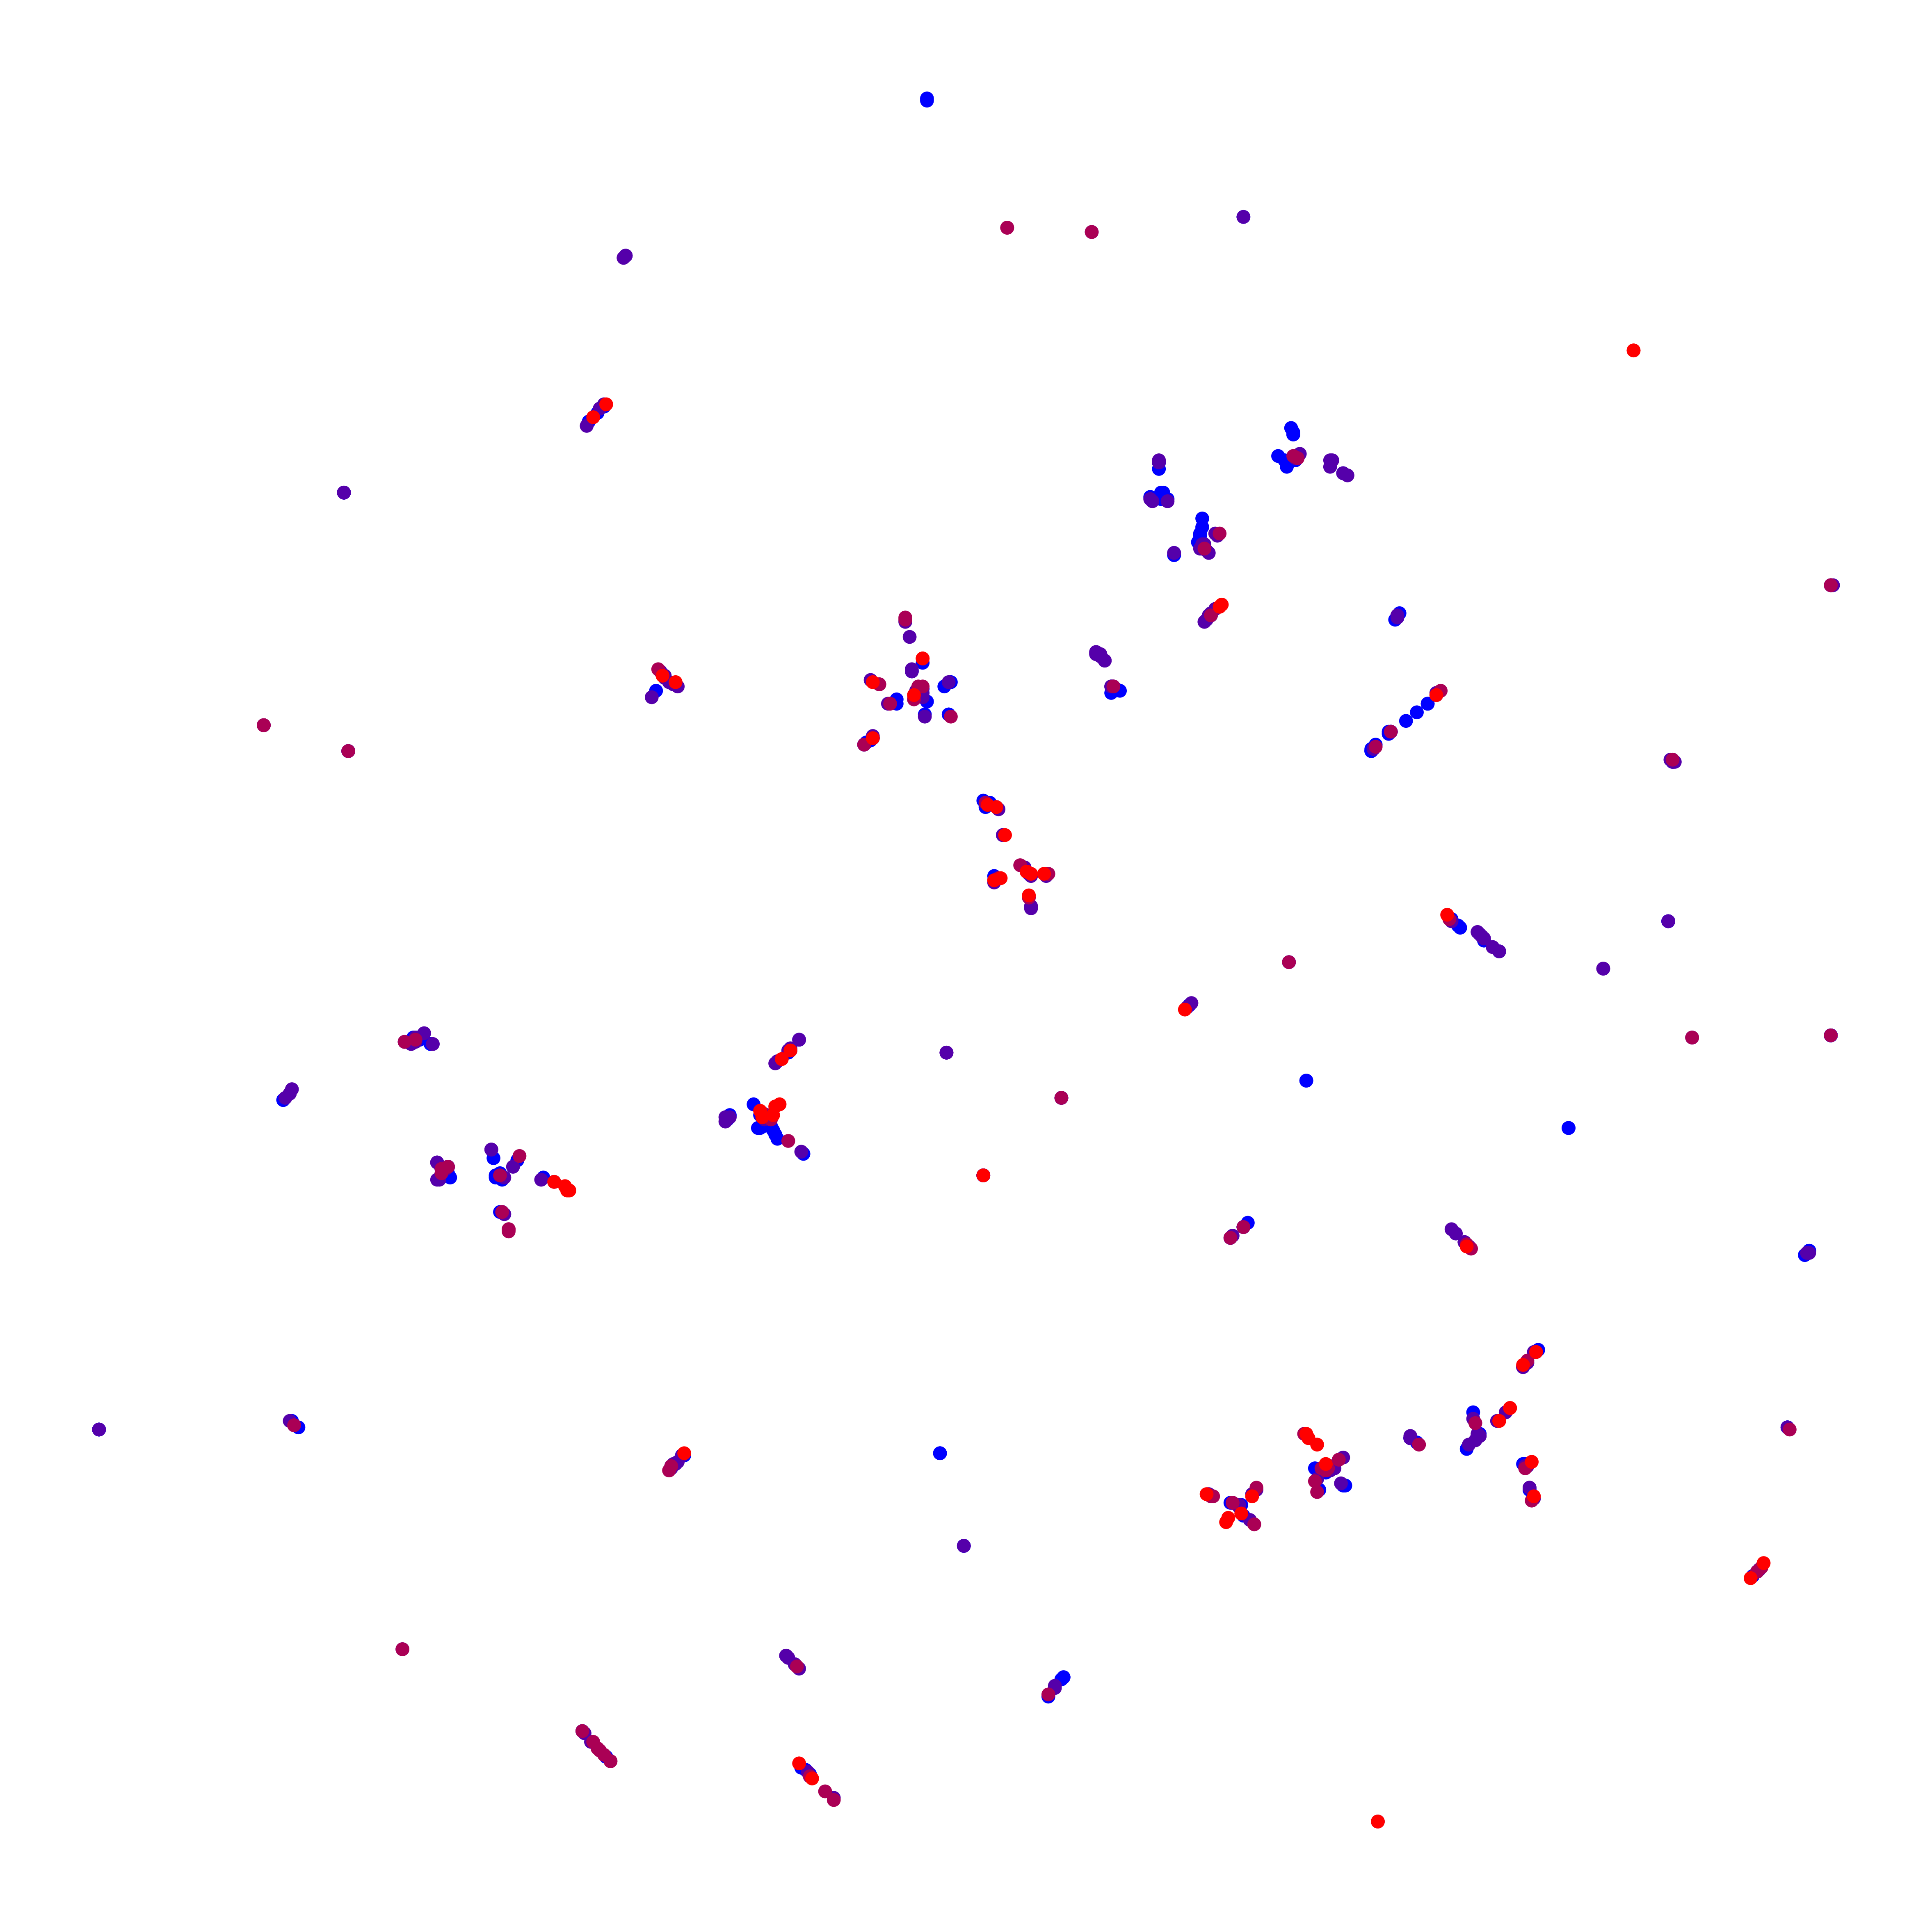

In [34]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

# embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")

## Clustering

In [35]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=10,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=10,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    # cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
241,3f71a7249834b5360afa6f1a30dc528db305df8b9c298f...,2024-02-16 08:24:38.918983,en,technologyreview.com,technologyreview.com,2023-11-21,The 2024 35 Innovators Under 35 competition is...,https://www.technologyreview.com/2023/11/21/10...,2023,The 2024 35 Innovators Under 35 competition is...,...,"[Breakthrough Technologies, Breakthrough Techn...",The 2024 35 Innovators Under 35 competition is...,558,"(The, 2024, 35, Innovators, Under, 35, competi...",Innovators competition nomination Innovators c...,1,#5500aa,419.0,459.0,p_5
588,f45ae4acba39c1d86b044cfb79d091aa17186744f138f9...,2024-05-07 15:42:27.269711,en,technologyreview.com,technologyreview.com,2022-06-24,"The Download: Yann LeCun’s AI vision, and smar...",https://www.technologyreview.com/2022/06/24/10...,2022,"The Download: Yann LeCun’s AI vision, and smar...",...,"[the House of Representatives, LeCun, Meta, AI...","The Download: Yann LeCun’s AI vision, and smar...",1429,"(The, Download, :, Yann, LeCun, ’s, AI, vision...",Download Yann LeCun vision city promise Online...,0,#aa0055,289.0,375.0,n_2
280,d09bfca7e243a460d26ec907422979518461e4c3a889ab...,2024-02-19 18:29:38.499538,en,technologyreview.com,technologyreview.com,2023-10-06,mRNA vaccines just won a Nobel Prize. Now they...,https://www.technologyreview.com/2023/10/06/10...,2023,mRNA vaccines just won a Nobel Prize. Now they...,...,[the Nobel Committee for Physiology or Medicin...,mRNA vaccines just won a Nobel Prize. Now they...,1411,"(mRNA, vaccines, just, won, a, Nobel, Prize, ....",vaccine Nobel Prize act scientist mRNA bevy va...,1,#5500aa,261.0,404.0,p_12


{'p_5', 'p_1', 'n_2', 'p_8', 'n_0', 'p_3', 'n_4', 'p_13', 'p_2', 'p_4', 'p_10', 'p_0', '-1', 'n_3', 'p_9', 'p_11', 'p_7', 'n_1', 'p_12', 'p_6'}


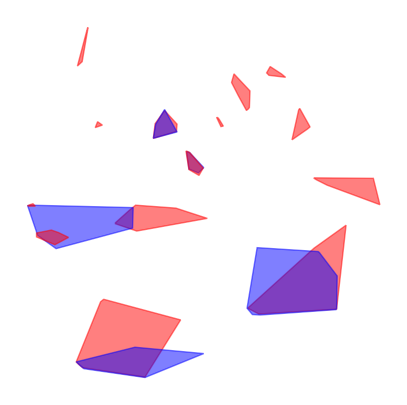

In [36]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [37]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
612,f8e31a605eeb6ffee8a03ff3d922cc56cc2c91c8a6780f...,2024-05-10 12:36:59.056033,en,technologyreview.com,technologyreview.com,2022-05-12,Transforming the automotive supply chain for t...,https://www.technologyreview.com/2022/05/12/10...,2022,Sponsored\nTransforming the automotive supply ...,...,"[Toyota, Cox Automotive, Nissan, JIT, Toyota, ...",Sponsored\nTransforming the automotive supply ...,1619,"(Sponsored, \n, Transforming, the, automotive,...",supply chain century Cloud solution manufactur...,0,#aa0055,667.0,264.0,n_1


# Explorin the clusters

In [58]:
df = pd.read_csv('src/data/entities.csv')

In [27]:
df.head(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,ORG,text_clean,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,2024 Innovator of the Year: Shawn Shan builds ...,941,2024 Innovator of the Year: Shawn Shan builds ...,Innovator Shawn Shan tool artist Shan Glaze Ni...,2,#0000ff,674.0,726.0,p_10


In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

In [7]:
df['cluster'].value_counts()

cluster
-1      129
p_3      64
n_1      38
p_11     37
p_5      34
p_8      32
p_1      30
p_12     29
n_2      24
p_10     21
p_6      20
p_4      18
p_9      18
n_3      16
n_4      15
p_7      14
n_0      14
p_0      13
p_13     13
p_2      11
Name: count, dtype: int64

In [8]:
df['cluster'].nunique()

20

In [28]:
# Extract keywords for each cluster
cluster_keywords = {}
for cluster_id, group in df.groupby('cluster'):
    print(f"\n--- Cluster {cluster_id} ---")


--- Cluster -1 ---

--- Cluster n_0 ---

--- Cluster n_1 ---

--- Cluster n_2 ---

--- Cluster n_3 ---

--- Cluster n_4 ---

--- Cluster p_0 ---

--- Cluster p_1 ---

--- Cluster p_10 ---

--- Cluster p_11 ---

--- Cluster p_12 ---

--- Cluster p_13 ---

--- Cluster p_2 ---

--- Cluster p_3 ---

--- Cluster p_4 ---

--- Cluster p_5 ---

--- Cluster p_6 ---

--- Cluster p_7 ---

--- Cluster p_8 ---

--- Cluster p_9 ---


In [29]:
# Get all text for this cluster
texts = group['parsed_lemmas'].tolist()

In [31]:
# Vectorize the text
vectorizer = CountVectorizer(max_features=1000)  # Limit vocabulary size
X = vectorizer.fit_transform(texts)

In [53]:
# Initialize an empty list to store results
results = []

# Extract keywords for each cluster
for cluster_id, group in df.groupby('cluster'):
    # Get all text for this cluster
    texts = group['parsed_lemmas'].tolist()

    # Vectorize the text
    vectorizer = CountVectorizer(max_features=1000)  # Limit vocabulary size
    X = vectorizer.fit_transform(texts)

    # Sum the frequencies of each word
    word_sums = X.sum(axis=0)
    words_freq = [(word, word_sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Get the top 5 keywords
    top_keywords = [word for word, freq in sorted_words[:15]]
    
    # Append results to the list
    results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

# Convert results to a DataFrame
keywords_df = pd.DataFrame(results)

In [54]:
# Save the DataFrame to an Excel file
keywords_df.to_excel("keywords_per_cluster.xlsx", index=False)

In [59]:
# Read the Excel file
keywords_df = pd.read_excel('keywords_per_cluster.xlsx')

In [60]:
keywords_df.head(1)

,cluster,top_keywords,chatgpt name
0,-1,"['datum', 'model', 'company', 'people', 'syste...",Business Intelligence and Tools


In [61]:
# Merge the two DataFrames on the 'cluster' column
merged_df = df.merge(keywords_df, on='cluster', how='left')


In [63]:
merged_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,...,word_count,parsed_doc,parsed_lemmas,temperature,color,x,y,cluster,top_keywords,chatgpt name
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,...,941,2024 Innovator of the Year: Shawn Shan builds ...,Innovator Shawn Shan tool artist Shan Glaze Ni...,2,#0000ff,674.0,726.0,p_10,"['model', 'image', 'system', 'openai', 'compan...",AI Models and Creative Tools
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,...,1366,What impact will AI have on video game develop...,impact video game development working conditio...,2,#0000ff,647.0,732.0,p_10,"['model', 'image', 'system', 'openai', 'compan...",AI Models and Creative Tools
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",...,1772,"To be more useful, robots need to become lazie...",robot Smarter datum processing machine energy ...,2,#0000ff,696.0,606.0,p_6,"['robot', 'model', 'datum', 'robotic', 'task',...",Robotics and Human Interaction
3,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,...,972,Roblox is launching a generative AI that build...,roblox environment snap game environment platf...,2,#0000ff,644.0,734.0,p_10,"['model', 'image', 'system', 'openai', 'compan...",AI Models and Creative Tools
4,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,...,1482,Sponsored\nIntegrating security from code to c...,Integrating security code today source softwar...,2,#0000ff,746.0,504.0,p_4,"['datum', 'system', 'content', 'example', 'len...",Cybersecurity and User Tools


In [41]:
# Filter the headlines belonging to cluster 
cluster_id = 'p_4'
cluster_headlines = df[df['cluster'] == cluster_id]['parsed_lemmas']

# Randomly select 10 headlines (or less if there aren't enough) with the seed directly in the same line
random_headlines = random.Random(0).sample(cluster_headlines.tolist(), min(20, len(cluster_headlines)))

# Convert the list of headlines into a string to pass to the API
headlines_text = "\n".join(random_headlines)
print(headlines_text)

Turbo productivity Asia benefit Generative potential creativity discovery efficiency trillion economy bymicrosoft ability arrange content gamechanger potential lab community Silicon Valley instance barrier participation age creator workforce shift process production economy turn type task skill Microsoft advisory firm Access Partnership partner Analytics Association Philippines Federation Indian Chambers Commerce Industry FICCI Center Global Communications GLOCOM Japan country level research impact Asia research boost capacity India Japan Philippines study Malaysia Indonesia South Korea country finding study instance report McKinsey estimate economy growth implication type work impact digitalization product injection productivity channel potential creativity discovery efficiency future copilot people ability role evolution task role job example Access Partnership research project worker India work activity implication industry job skill unleashing creativity update Renaissance ability 

In [195]:
df['color'].value_counts()

color
#5500aa    225
#0000ff    209
#aa0055     95
#ff0000     61
Name: count, dtype: int64

In [196]:
#Filter by colour

selected_color = '#ff0000'
unique_clusters = df.loc[df['color'] == selected_color, 'cluster'].unique()
if unique_clusters.size > 0:
    print(f"The unique clusters for color {selected_color} are: {list(unique_clusters)}")
else:
    print(f"Color {selected_color} not found in the dataset.")


The unique clusters for color #ff0000 are: ['n_2', 'n_4', 'n_3', 'n_1', 'n_0', '-1', 'n_5']
